In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from scipy import stats
import numpy as np
import textwrap
import random 
import cv2
import os
import shutil
import warnings

warnings.filterwarnings('ignore')

In [2]:
finetune_df_merged = pd.read_csv("results/data/finetune_data_probs.csv")
pretrain_df_merged = pd.read_csv("results/data/pretrain_data_probs.csv")

finetune_df_merged.drop_duplicates(inplace=True)
pretrain_df_merged.drop_duplicates(inplace=True)

In [3]:
finetune_df_merged.reset_index(drop=True, inplace=True)
pretrain_df_merged.reset_index(drop=True, inplace=True)

In [4]:
finetune_df_merged["full_lora_abs_diff"] = np.abs(finetune_df_merged["full_lora_diff"])
pretrain_df_merged["full_lora_abs_diff"] = np.abs(pretrain_df_merged["full_lora_diff"])

In [5]:
# Function to bin a variable in the dataframe
def bin_var(df, var, abs=True, n=4):
    var_vals = df[var]
    if abs:
        var_vals = np.abs(var_vals)

    percentiles_at = np.linspace(0, 1, n+1)

    bins = list(var_vals.quantile(percentiles_at))
    labels = [f"Q{i+1}: {round(bins[i], 3)}-{round(bins[i+1], 3)}" for i in range(len(bins)-1)]
    df[f"{var}_bins"] = pd.cut(var_vals, bins=bins, labels=labels, include_lowest=True)
    return df

In [6]:
finetune_df_merged = bin_var(finetune_df_merged, var="full_lora_diff", abs=True, n=10)
pretrain_df_merged = bin_var(pretrain_df_merged, var="full_lora_diff", abs=True, n=10)

In [7]:
tot_ft_tkn_count = len(finetune_df_merged)
tot_pt_tkn_count = len(pretrain_df_merged)

ft_prob = finetune_df_merged["curr_token_freq"] / tot_ft_tkn_count
pt_prob = finetune_df_merged["pt_curr_token_freq"] / tot_pt_tkn_count

finetune_df_merged["rel_prev"] = round(ft_prob - pt_prob, 3)

In [8]:
# Sample n points from both datasets to get less crowded plots
n = 50000
pretrain_sample = pretrain_df_merged.loc[random.sample(range(len(pretrain_df_merged)), n)]
finetune_sample = finetune_df_merged.loc[random.sample(range(len(finetune_df_merged)), n)]

In [9]:
def get_region(df, a, b): 
    x1, x2, y1, y2 = a[0], a[1], b[0], b[1]
    indices = (df["full_base_diff"] > x1) & (df["full_base_diff"] < x2) & (df["lora_base_diff"] < y2) & (df["lora_base_diff"] > y1)
    return df[indices]

In [10]:
# First quadrant ((lora_base_diff) > 0 and (full_base_diff > 0))

full_base_int = (0.00, 1.00)
lora_base_int = (0.00, 1.00)

first_quad = get_region(finetune_df_merged, full_base_int, lora_base_int)

# r1
full_base_int = (0.00, 0.25)
lora_base_int = (0.75, 1.00)

r1 = get_region(first_quad, full_base_int, lora_base_int)
r1.to_csv("results/data/examples_r1.csv", index=False)

# r2
full_base_int = (0.75, 1.00)
lora_base_int = (0.00, 0.25)

r2 = get_region(first_quad, full_base_int, lora_base_int)
r2.to_csv("results/data/examples_r2.csv", index=False)

# r3: along diagonal 
r3 = first_quad[first_quad["full_lora_abs_diff"] < 0.001]
r3.to_csv("results/data/examples_r3.csv", index=False)

r_3a = r3[r3["full_lora_diff"] < 0.00] # above diagonal
r_3b = r3[r3["full_lora_diff"] > 0.00] # below diagonal

r_3a.to_csv("results/data/examples_r3a.csv", index=False)
r_3b.to_csv("results/data/examples_r3b.csv", index=False)

full_base_int = (-1.00, 0.00)
lora_base_int = (-1.00, 0.00)

# 4th quadrant ((lora_base_diff) < 0 and (full_base_diff < 0))

fourth_quad = get_region(finetune_df_merged, full_base_int, lora_base_int)

# r4
r4 = fourth_quad[fourth_quad["full_lora_abs_diff"] < 0.001]
r4.to_csv("results/data/examples_r4.csv", index=False)


r_4a = r4[r4["full_lora_diff"] < 0.00] # above diagonal
r_4b = r4[r4["full_lora_diff"] > 0.00] # below diagonal

r_4a.to_csv("results/data/examples_r4a.csv", index=False)
r_4b.to_csv("results/data/examples_r4b.csv", index=False)


# r5
full_base_int = (-0.75, -0.5)
lora_base_int = (-0.25, 0.00)

r5 = get_region(fourth_quad, full_base_int, lora_base_int)
r5.to_csv("results/data/examples_r5.csv", index=False)

# r6
full_base_int = (-0.25, 0.00)
lora_base_int = (-0.75, -0.5)

r6 = get_region(fourth_quad, full_base_int, lora_base_int)
r6.to_csv("results/data/examples_r6.csv", index=False)


## Plotting relationship between full and lora

In [11]:
def scatterplot(df, x, y, xlabel=r"$PMI(w_i|w_{1:i-1})$", ylabel=r"$p_{full} - p_{lora}$", legend_title="Token probability of base model", save_path=None, hue="base_prob"):
    ax = sns.scatterplot(df, x=x, y=y, hue=hue, s=5, linewidth=0)
    wrapped_title = textwrap.fill(legend_title, width=18)
    ax.legend(title=legend_title, bbox_to_anchor=(1, 1))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [12]:
def plot_ft_div_all_feats(df, save_path): 
    f, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    sns.scatterplot(df, x="lora_base_diff", y="full_base_diff", hue="base_prob", s=5, linewidth=0, ax=axes[0])
    sns.scatterplot(df, x="lora_base_diff", y="full_base_diff", hue="pmi", s=5, linewidth=0, ax=axes[1])
    sns.scatterplot(df, x="lora_base_diff", y="full_base_diff", hue="curr_token_freq", s=5, linewidth=0, ax=axes[2])
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

In [13]:
def base_divergence(df, hue, diag, legend_title, plt_title=None, ax=None, save_path=None):
    # sns.jointplot(data=pretrain_df, x="pmi", y="base_lora_diff", alpha=0.5, s=5, linewidth=0, hue="base_prob_bin")
    scatter = sns.scatterplot(df, x="full_base_diff", y="lora_base_diff", hue=hue, s=5, linewidth=0, ax=ax)
    showplot = False
    if ax is None:
        ax = scatter
        showplot = True
    title=legend_title
    wrapped_title = textwrap.fill(title, width=18)
    ax.legend(title=wrapped_title, bbox_to_anchor=(1, 1))
    
    #Plot line along diagonal where p_full == p_lora
    if diag:
        ax.plot([-1, 1], [-1, 1], linestyle="dashed", color='r', linewidth=0.8)
    ax.set_xlabel(r"$p_{full} - p_{base}$")
    ax.set_ylabel(r'$p_{lora} - p_{base}$')
    ax.set_title(plt_title)
    if plt_title is not None: 
        ax.set_title(plt_title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

    if showplot:
        plt.show()

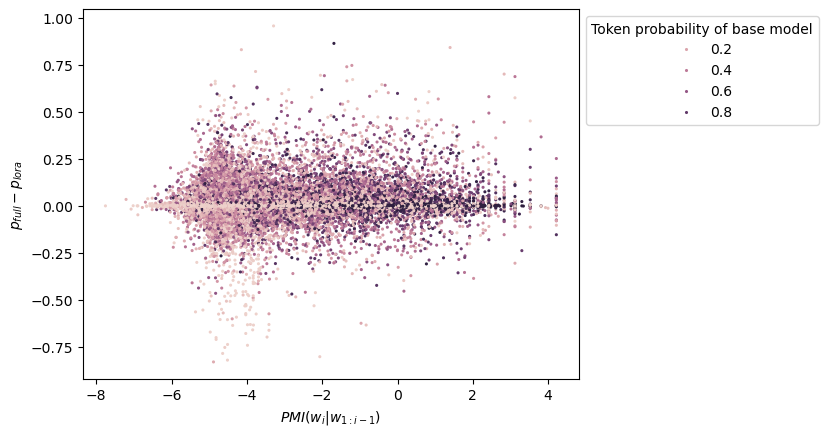

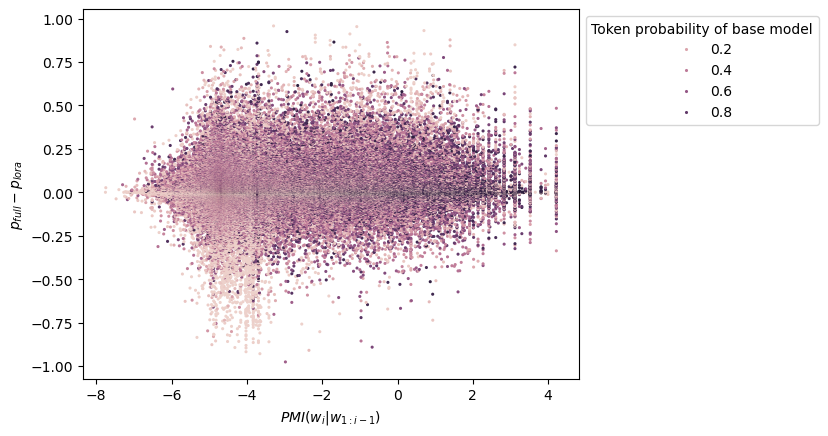

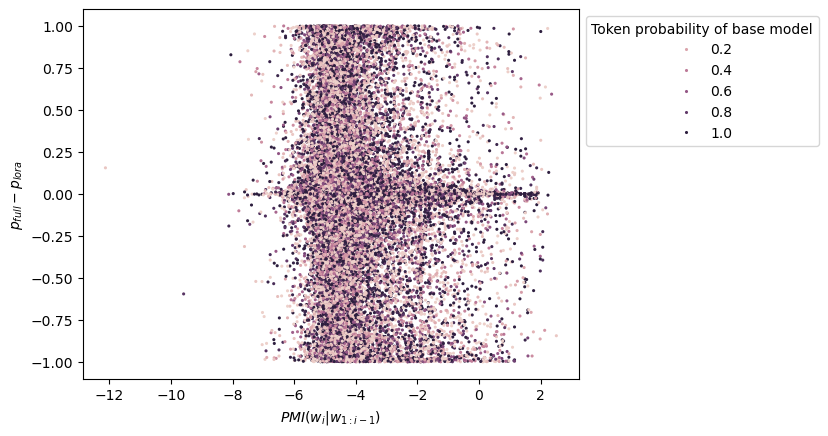

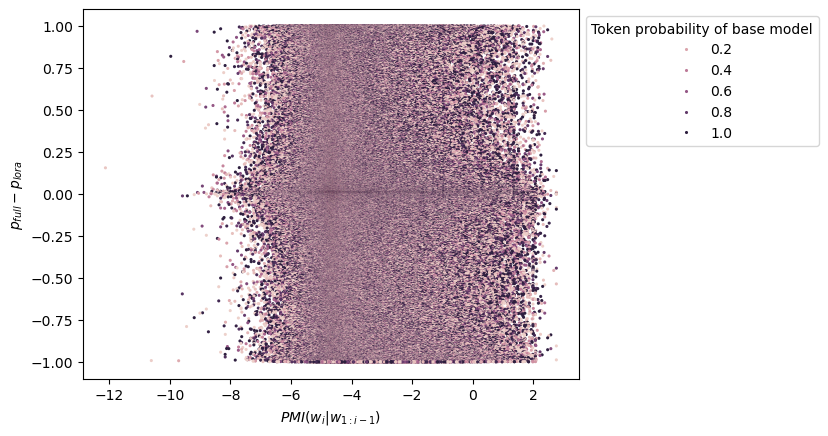

In [15]:
scatterplot(finetune_sample, x="pmi", y="full_lora_diff", save_path="results/plots/finetuning/sampled/full_lora_diff.png")
scatterplot(finetune_df_merged, x="pmi", y="full_lora_diff", save_path="results/plots/finetuning/full/full_lora_diff.png")
scatterplot(pretrain_sample, x="pmi", y="full_lora_diff", save_path="results/plots/pretraining/sampled/full_lora_diff.png")
scatterplot(pretrain_df_merged, x="pmi", y="full_lora_diff", save_path="results/plots/pretraining/full/full_lora_diff.png")

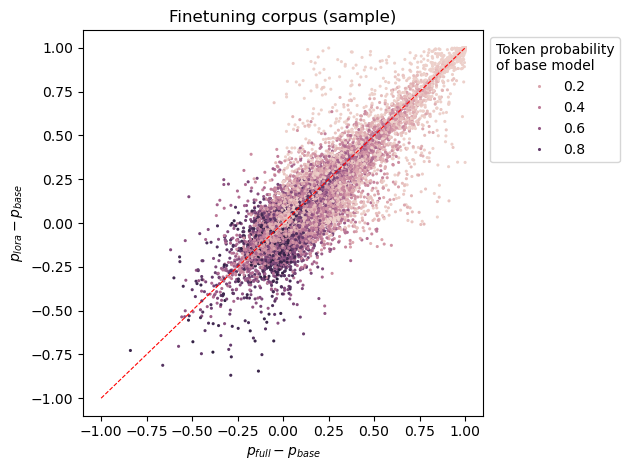

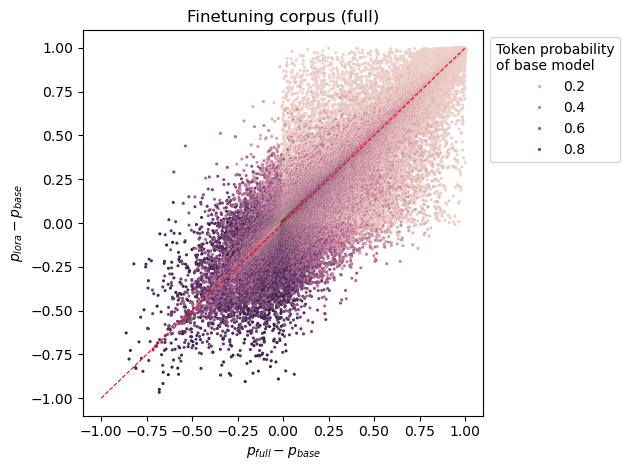

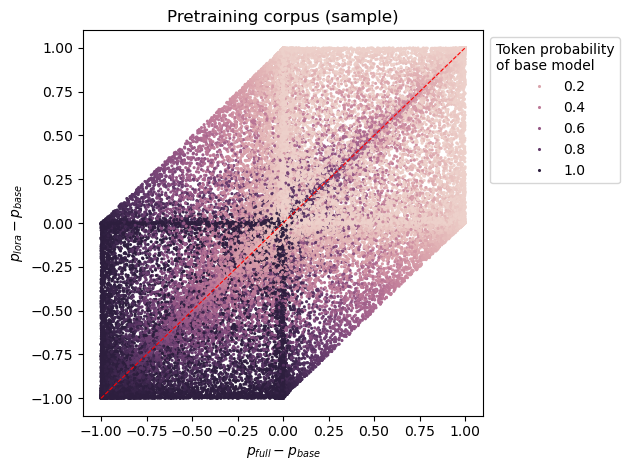

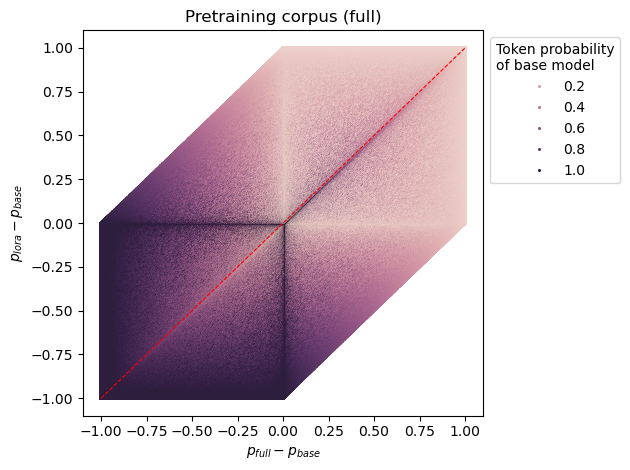

In [32]:
base_divergence(finetune_sample, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Finetuning corpus (sample)", save_path = "results/plots/finetuning/sampled/lora_vs_full_movement.png")
base_divergence(finetune_df_merged, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Finetuning corpus (full)", save_path = "results/plots/finetuning/full/lora_vs_full_movement.png")
base_divergence(pretrain_sample, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Pretraining corpus (sample)", save_path = "results/plots/pretraining/sampled/lora_vs_full_movement.png")
base_divergence(pretrain_df_merged, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Pretraining corpus (full)", save_path = "results/plots/pretraining/full/lora_vs_full_movement.png")

## Analysis of LoRA-FF differences 
### Attributing differences to tokens in finetuning corpus

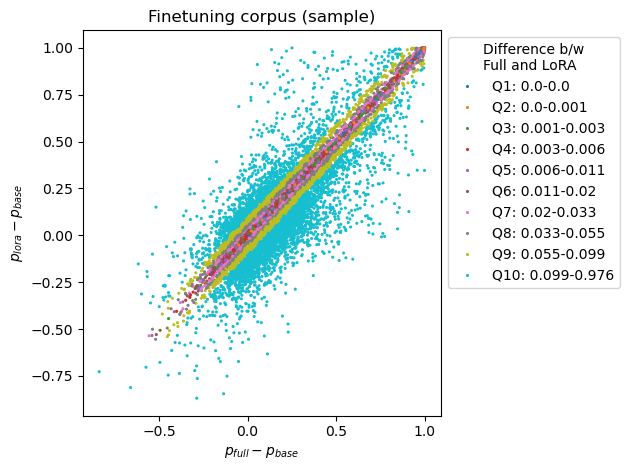

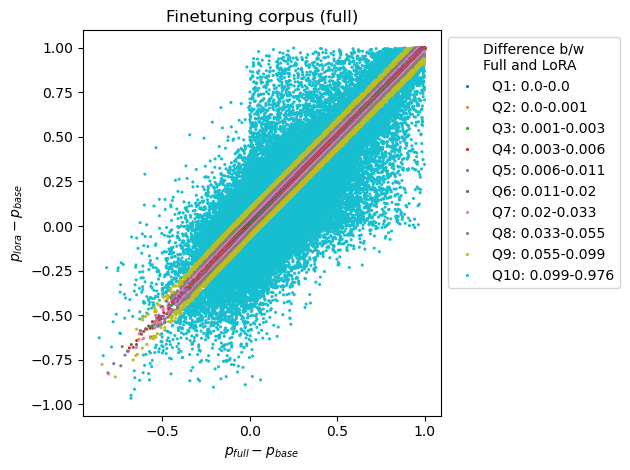

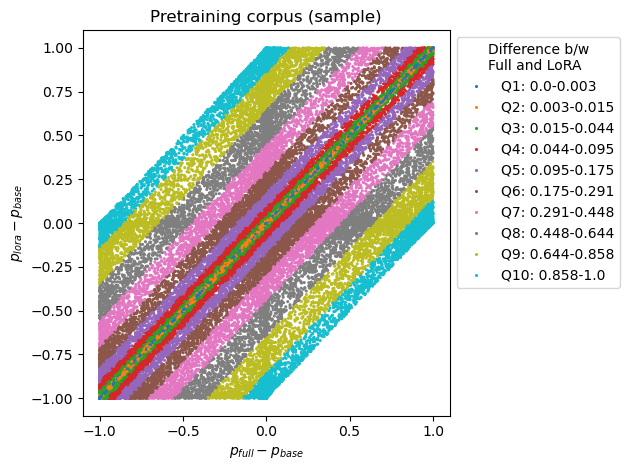

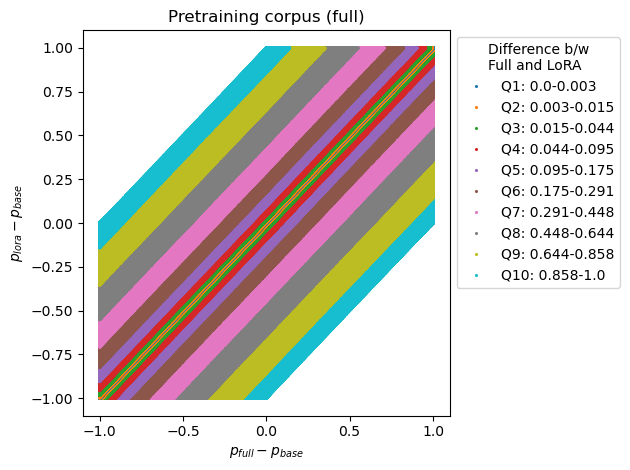

In [33]:
# Repeat above experiment but with quantiles of full_lora_diff
base_divergence(finetune_sample, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Finetuning corpus (sample)", diag=False, save_path = "results/plots/finetuning/sampled/lora_vs_full_movement_binned.png")
base_divergence(finetune_df_merged, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Finetuning corpus (full)", diag=False, save_path = "results/plots/finetuning/full/lora_vs_full_movement_binned.png")

base_divergence(pretrain_sample, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Pretraining corpus (sample)", diag=False, save_path = "results/plots/pretraining/sampled/lora_vs_full_movement_binned.png")
base_divergence(pretrain_df_merged, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Pretraining corpus (full)", diag=False, save_path = "results/plots/pretraining/full/lora_vs_full_movement_binned.png")

In [34]:
ft_stats = finetune_df_merged.groupby('full_lora_diff_bins').describe()
pt_stats = pretrain_df_merged.groupby('full_lora_diff_bins').describe()

In [35]:
threshold = 0.0

lora_greater_threshold = finetune_df_merged[finetune_df_merged.full_lora_diff < -threshold]
full_greater_threshold = finetune_df_merged[finetune_df_merged.full_lora_diff > threshold]
full_lora_eq_threshold = finetune_df_merged[finetune_df_merged.full_lora_diff == threshold]

print("Finetuning corpus stats when p(lora) > p(full)")
stats = round(lora_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
display(stats)
print("Finetuning corpus stats when p(lora) < p(full)")
stats = round(full_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
display(stats)
print("Finetuning corpus stats when p(lora) == p(full)")
stats = round(full_lora_eq_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
display(stats)

Finetuning corpus stats when p(lora) > p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          213322.000       213322.000  213322.000
mean                0.029         4289.619       0.232
std                 0.058         7522.801       0.317
min                 0.000            1.000       0.000
25%                 0.001           35.000       0.004
50%                 0.008          246.000       0.061
75%                 0.033         4954.000       0.354
max                 0.976        26111.000       1.000

Finetuning corpus stats when p(lora) < p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          303553.000       303553.000  303553.000
mean                0.041         4310.613       0.315
std                 0.069         7504.012       0.352
min                 0.000            1.000       0.000
25%                 0.002           31.000       0.013
50%                 0.014          206.000       0.144
75%                 0.051         5363.000       0.589
max                 0.957        26111.000       1.000

Finetuning corpus stats when p(lora) == p(full)


full_lora_abs_diff  curr_token_freq  base_prob
count                 7.0            7.000      7.000
mean                  0.0         1769.429      0.835
std                   0.0         2216.092      0.369
min                   0.0            6.000      0.003
25%                   0.0          144.500      0.922
50%                   0.0          168.000      0.998
75%                   0.0         3280.000      1.000
max                   0.0         5363.000      1.000

In [36]:
threshold = 0.0
lora_greater_threshold = pretrain_df_merged[pretrain_df_merged.full_lora_diff < -threshold]
full_greater_threshold = pretrain_df_merged[pretrain_df_merged.full_lora_diff > threshold]
full_lora_eq_threshold = pretrain_df_merged[pretrain_df_merged.full_lora_diff == threshold]

stats=round(lora_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
print("Pretraining corpus stats when p(lora) > p(full)")
display(stats)

stats=round(full_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
print("Pretraining corpus stats when p(lora) < p(full)")
display(stats)

stats=round(full_lora_eq_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
print("Pretraining corpus stats when p(lora) == p(full)")
display(stats)

Pretraining corpus stats when p(lora) > p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          761657.000       761657.000  761657.000
mean                0.305        13862.558       0.452
std                 0.320        22564.949       0.402
min                 0.000            1.000       0.000
25%                 0.027          150.000       0.039
50%                 0.173         1502.000       0.349
75%                 0.539        21657.000       0.926
max                 1.000        72634.000       1.000

Pretraining corpus stats when p(lora) < p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          801178.000       801178.000  801178.000
mean                0.308        10164.637       0.453
std                 0.321        20854.013       0.403
min                 0.000            1.000       0.000
25%                 0.028           83.000       0.039
50%                 0.178          538.000       0.352
75%                 0.543         5064.000       0.929
max                 1.000        72634.000       1.000

Pretraining corpus stats when p(lora) == p(full)


full_lora_abs_diff  curr_token_freq  base_prob
count               287.0          287.000    287.000
mean                  0.0        19926.206      0.694
std                   0.0        16791.754      0.390
min                   0.0           16.000      0.000
25%                   0.0         5036.000      0.375
50%                   0.0        22036.000      0.962
75%                   0.0        22036.000      1.000
max                   0.0        72634.000      1.000

### Plotting frequencies of full - lora along diagonal 
- might be better to try a different approach (skip this section for now)

In [37]:
# Plotting along the diagonal 

split_points = np.linspace(-1, 1, 21)
xy_pairs = [(round(split_points[i], 1), round(split_points[i+1], 1)) for i in range(len(split_points)-1)]
full_lora_diff_threshold, lora_full_diff_threshold = 0.0, 0.0
xy_along_hist = pd.DataFrame(columns=["range", "total", "full_greater", "lora_greater"])

for xy in xy_pairs:
    diff_range = f"{xy[0]}-{xy[1]}"
    region_df1 = get_region(finetune_df_merged, xy, xy)
    region_df2 = get_region(finetune_df_merged, (xy[0], xy[1]), (-1, xy[1]))
    region_df3 = get_region(finetune_df_merged, (-1, xy[0]), (xy[0], xy[1]))
    region_df = pd.concat([region_df1, region_df2, region_df3])
    region_df = region_df[["curr_token", "lora_base_diff", "full_base_diff", "full_lora_diff", "rel_prev"]]
    total, full_greater, lora_greater = len(region_df), len(region_df[region_df["full_lora_diff"] > full_lora_diff_threshold]), len(region_df[region_df["full_lora_diff"] < lora_full_diff_threshold])
    new_row = {"range": diff_range, "total": total, "full_greater": full_greater, "lora_greater": lora_greater}
    xy_along_hist.loc[len(xy_along_hist)] = new_row
    xy_along_hist.reset_index(drop=True, inplace=True)


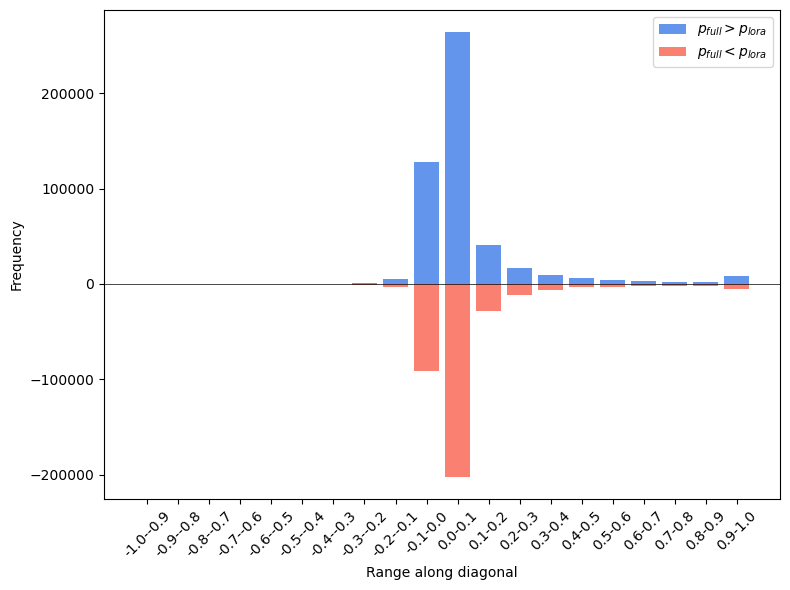

In [38]:
# Mirror Bar plot of the distribution of points along the diagonal with respect to the range
plt.figure(figsize=(8, 6))

# Create mirror bar plot
plt.bar(xy_along_hist["range"], xy_along_hist["full_greater"], label=r"$p_{full} > p_{lora}$", color='cornflowerblue')
plt.bar(xy_along_hist["range"], -xy_along_hist["lora_greater"], label=r"$p_{full} < p_{lora}$", color='salmon')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Set labels
plt.xlabel("Range along diagonal")
plt.ylabel("Frequency")

# rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# add legend
plt.legend()

## Categorizing the plot into different regions 
<img src="results/figs/regions.png" alt="drawing" width="600"/>

## Exploring Relative Corpus Prevalence when $p_{lora} > p_{base}$ and $p_{full} > p_{base}$

We define the `rel_prev` feature to capture the relative prevalence of a token in the finetuning corpus as compared to its occurrence in the pretraining corpus.


(0.0, 1.0)

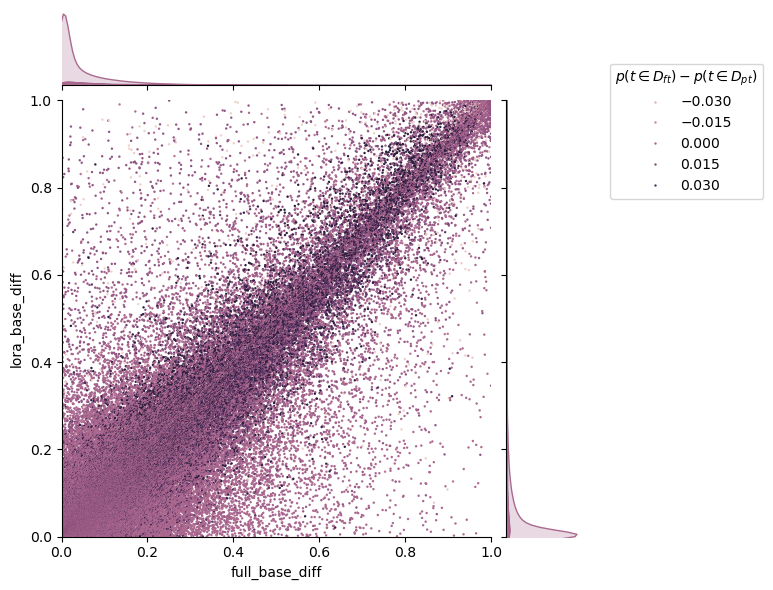

In [39]:
g = sns.jointplot(first_quad, x="full_base_diff", y="lora_base_diff", hue="rel_prev", s=3, linewidth=0)
legend = g.ax_joint.get_legend()
legend.set_loc("upper right")
legend.set_bbox_to_anchor((1.65, 1.1))
legend.set_title(r"$p(t \in D_{ft}) - p(t \in D_{pt})$")
g.ax_marg_x.set_xlim(0,1)
g.ax_marg_y.set_ylim(0,1)

In [22]:
ft_prev = first_quad[(first_quad["rel_prev"] > 0.0)]
pt_prev = first_quad[(first_quad["rel_prev"] < 0.0)]
eq_prev = first_quad[(first_quad["rel_prev"] == 0.0)]

In [54]:
def create_jointplot(df, title, title_fontsize=10, x="full_base_diff", y="lora_base_diff", hue="token_in_context"):

   # First subplot: JointGrid for 'total_bill' and 'tip'
   g1 = sns.JointGrid(data=df, x=x, y=y, hue=hue, height=4, dropna=True)
   g1.plot_joint(sns.scatterplot,s=4,linewidth=0)

   # g1.ax_joint.set_ylim(-0.2,1)
   g1.ax_marg_x.set_xlim(0,1)
   g1.figure.suptitle(title, fontsize=title_fontsize, y=0.95)
   g1.ax_marg_y.set_ylim(0,1)

   g1.plot_marginals(sns.kdeplot, multiple="stack", fill=True, common_norm=False, linewidth=0)
   handles, labels = g1.ax_joint.get_legend_handles_labels()
   if g1.ax_joint.legend_ is not None:
      g1.ax_joint.legend_.remove()

   plt.tight_layout()
   
   return plt, handles, labels

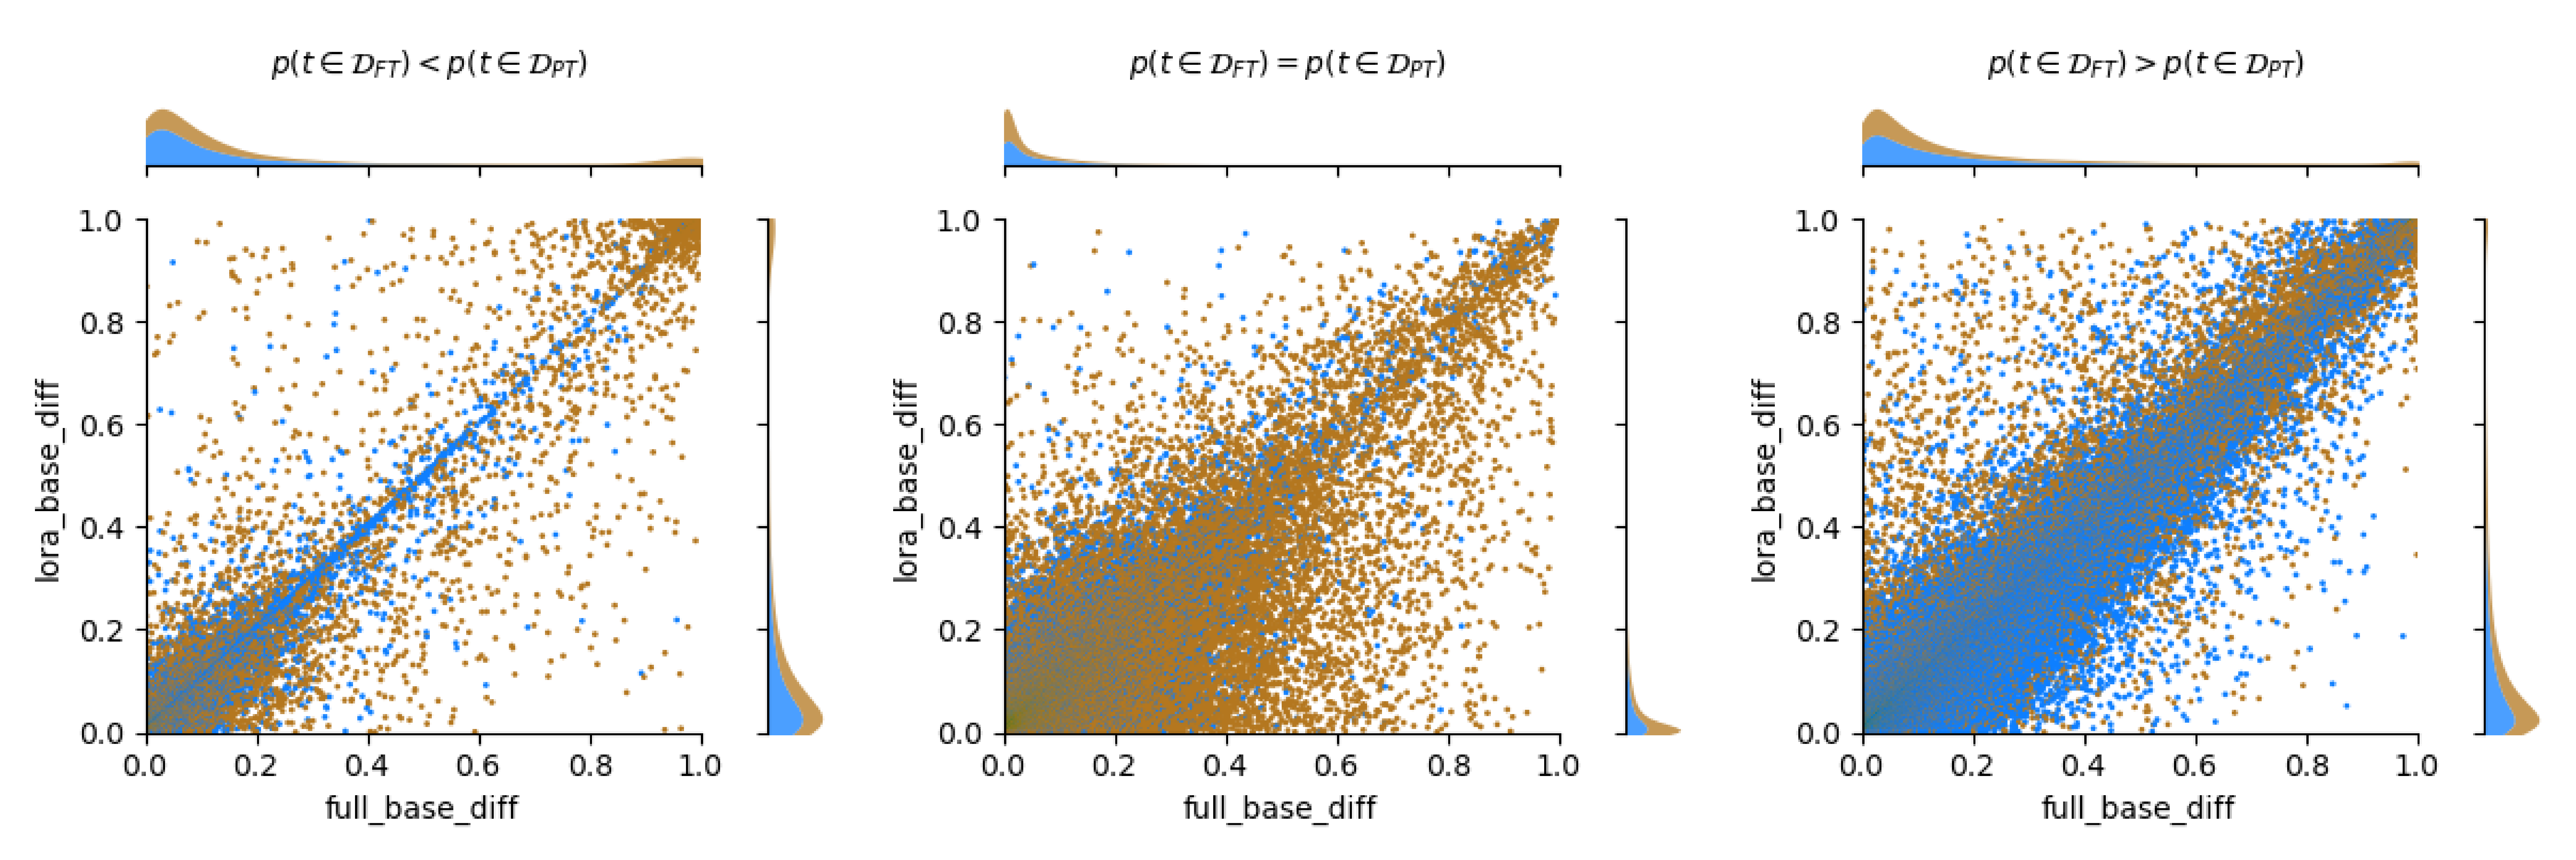

In [55]:
fig, axarr = plt.subplots(1,3, figsize=(90,50))
# plt.subplots_adjust()
# stitch plots together
dfs = [pt_prev, eq_prev, ft_prev]
titles = [r"$p(t \in \mathcal{D}_{FT}) < p(t \in \mathcal{D}_{PT})$", r"$p(t \in \mathcal{D}_{FT}) = p(t \in \mathcal{D}_{PT})$", r"$p(t \in \mathcal{D}_{FT}) > p(t \in \mathcal{D}_{PT})$"]

tmp_dir = "results/plots/finetuning/full/tmp"
os.makedirs(tmp_dir, exist_ok=True)
for i, df in enumerate(dfs):
   
   g, handles, labels = create_jointplot(df, title=titles[i])
   filepath=os.path.join(tmp_dir, f"image_{i}.png")
   g.savefig(filepath)
   g.close()

   im = cv2.imread(filepath)
   axarr[i].imshow(im)
   axarr[i].axis("off")


# fig.legend(handles, ["Token not in context", "Token in context"], loc='lower center', bbox_to_anchor=(0.5, -.1), fontsize=100, ncol=2, markerscale=20)
plt.subplots_adjust(wspace=0, hspace=0, top=0.6)
plt.tight_layout()
plt.savefig("results/plots/finetuning/full/prevalence_plots.png", bbox_inches='tight')
shutil.rmtree(tmp_dir)


In [56]:
blocks = 6
rel_prev_ranges = np.linspace(finetune_df_merged["rel_prev"].min(), finetune_df_merged["rel_prev"].max(), blocks)
rel_prev_ranges = [(rel_prev_ranges[i], rel_prev_ranges[i+1]) for i in range(blocks-1)]

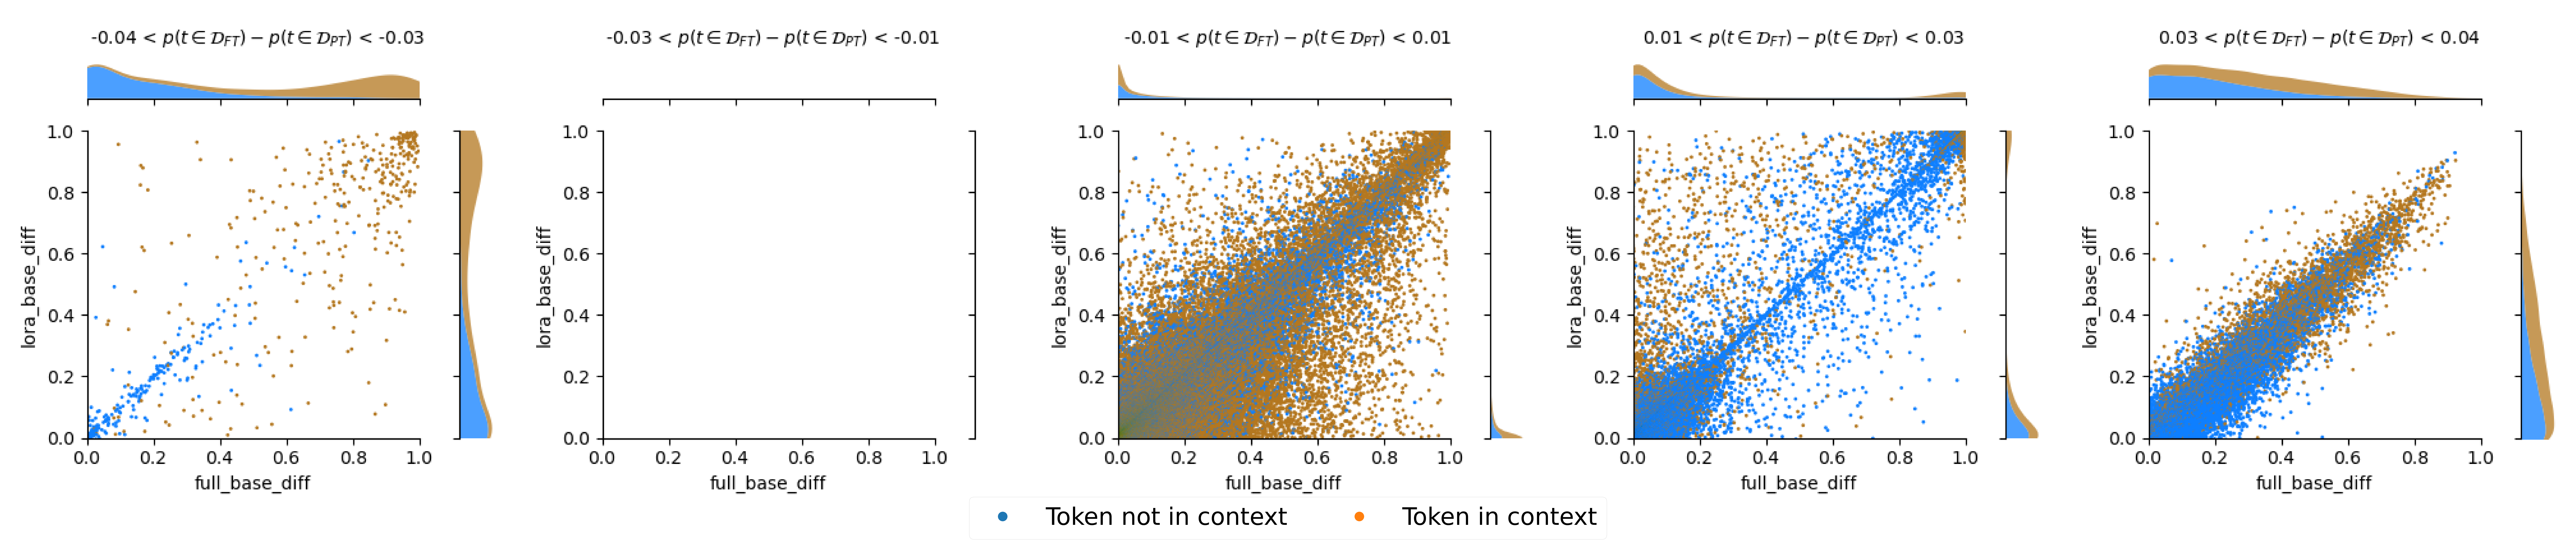

In [57]:
fig, axarr = plt.subplots(1,blocks-1, figsize=(150,30))
# stitch plots together
dfs = [finetune_df_merged[(finetune_df_merged["rel_prev"] > l) & (finetune_df_merged["rel_prev"] < r)] for l, r in rel_prev_ranges]
latex_str = r"$p(t \in \mathcal{D}_{FT}) - p(t \in \mathcal{D}_{PT})$"
titles = [f"{round(l, 2)} < {latex_str} < {round(r, 2)}" for l, r in rel_prev_ranges]

tmp_dir = "results/plots/finetuning/full/tmp"
os.makedirs(tmp_dir, exist_ok=True)
for i, df in enumerate(dfs):
   g, handles, labels = create_jointplot(df, title=titles[i], title_fontsize=10)
   filepath=os.path.join(tmp_dir, f"image_{i}.png")
   g.savefig(filepath)
   g.close()

   im = cv2.imread(filepath)
   axarr[i].imshow(im)
   axarr[i].axis("off")

fig.legend(handles, ["Token not in context", "Token in context"], loc='lower center', bbox_to_anchor=(0.5, -.07), fontsize=100, ncol=2, markerscale=20)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig("results/plots/finetuning/full/prevalence_plots_5_blocks.png", bbox_inches='tight')
shutil.rmtree(tmp_dir)

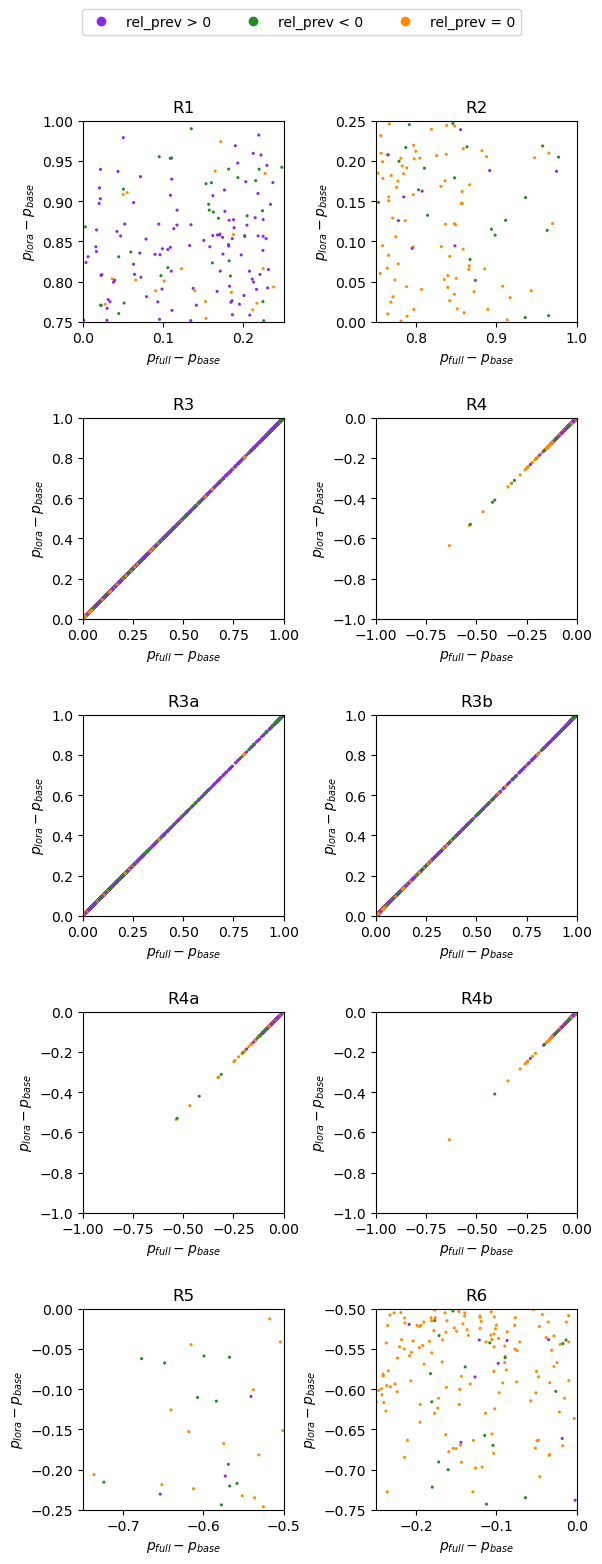

In [77]:
# Plotting the distribution of points in R1, R2, R3, R4, R5, R6 colored by rel_prev

choices = ['blueviolet', 'forestgreen', 'darkorange']

def plot_region(region_df, region_name, ax, norm):
    """Plot distribution of points in a region with respect to lora - base probability and full - base probability coloreed by rel_prev"""
    
    conditions = [
        (region_df['rel_prev'] > 0),
        (region_df['rel_prev'] < 0),
        (region_df['rel_prev'] == 0)
    ]
    
    region_df['color'] = np.select(conditions, choices, default='black')
    
    # Plot lora - base vs full - base
    scatter = ax.scatter(
        x=region_df['full_base_diff'], 
        y=region_df['lora_base_diff'], 
        c=region_df['color'], 
        norm=norm,
        cmap="pink_r",
        linewidth=0, 
        s=5
    )

    ax.set_title(region_name)
    ax.set_xlabel(r'$p_{full} - p_{base}$')
    ax.set_ylabel(r'$p_{lora} - p_{base}$')
    ax.set_aspect('equal')
    
    # Set limits based on region
    if region_name == "R1":
        ax.set_xlim(0, 0.25)
        ax.set_ylim(0.75, 1)
    elif region_name == "R2":
        ax.set_xlim(0.75, 1)
        ax.set_ylim(0, 0.25)
    elif region_name in ["R3", "R3a", "R3b"]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    elif region_name in ["R4", "R4a", "R4b"]:
        ax.set_xlim(-1, 0)
        ax.set_ylim(-1, 0)
    elif region_name == "R5":
        ax.set_xlim(-0.75, -0.5)
        ax.set_ylim(-0.25, 0)
    elif region_name == "R6":
        ax.set_xlim(-0.25, 0)
        ax.set_ylim(-0.75, -0.5)

    return scatter

# Create figure with 3x2 subplots
plot_grid = (5, 2)
rows, cols = plot_grid[0], plot_grid[1]
size = 3
figsize = (cols * size, rows * size)
vmin, vmax = finetune_df_merged["rel_prev"].min(), finetune_df_merged["rel_prev"].max()
fig, axs = plt.subplots(rows, cols, figsize=figsize)
region_dfs = [r1, r2, r3, r4, r_3a, r_3b, r_4a, r_4b,r5, r6]
region_names = ["R1", "R2", "R3", "R4", "R3a", "R3b", "R4a", "R4b", "R5", "R6"]

# Get the norm for consistent color scaling across all plots
all_rel_prev = pd.concat([df['rel_prev'] for df in region_dfs])
norm = plt.Normalize(vmin=vmin, vmax=vmax)

for i, region_df in enumerate(region_dfs):
    row = i // cols
    col = i % cols
    scatter = plot_region(region_df, region_names[i], axs[row, col], norm)

# Add single colorbar at top
# cbar_ax = fig.add_axes([0.3, 1.02, 0.4, 0.005])  # [left, bottom, width, height]
# cbar = fig.colorbar(scatter, ax=axs.ravel().tolist(), label='Relative Prevalence', shrink=0.25, cax=cbar_ax, orientation='horizontal')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=choices[0], label='rel_prev > 0', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=choices[1], label='rel_prev < 0', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=choices[2], label='rel_prev = 0', markersize=8)
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.savefig("results/plots/finetuning/full/region_plots.png", bbox_inches='tight')

### Takeaways

We consider 3 scenarios with respect to the relative prevalence: 

A. token is more likely to be present in the finetuning corpus than the pretraining corpus\
B. token is more likely to be present in the pretraining corpus than the finetuning corpus\
C. token is equally likely to be present in the pretraining corpus and finetuning corpus\

We find that the probability distribution of the divergence of full/lora from base probability remains the same for scenarios A and B (as evident in the marginal distributions), whereas when a token is equally in the 2 corpora (C), there is a higher likelihood of the divergence from base being lesser than that of A and B.

### Distribution of points

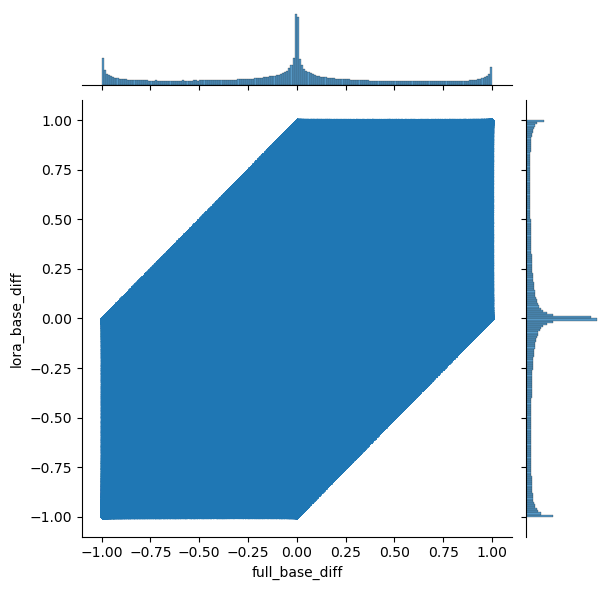

In [43]:
sns.jointplot(data=pretrain_df_merged, x="full_base_diff", y="lora_base_diff", s=5,linewidth=0)

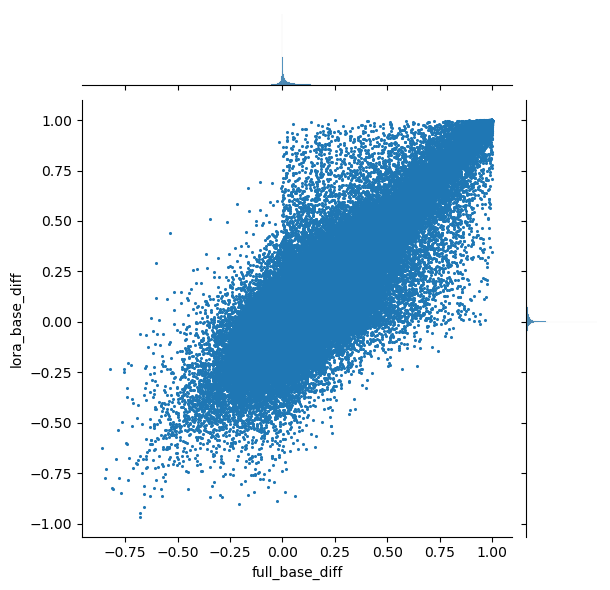

In [44]:
sns.jointplot(data=finetune_df_merged, x="full_base_diff", y="lora_base_diff", s=5,linewidth=0)

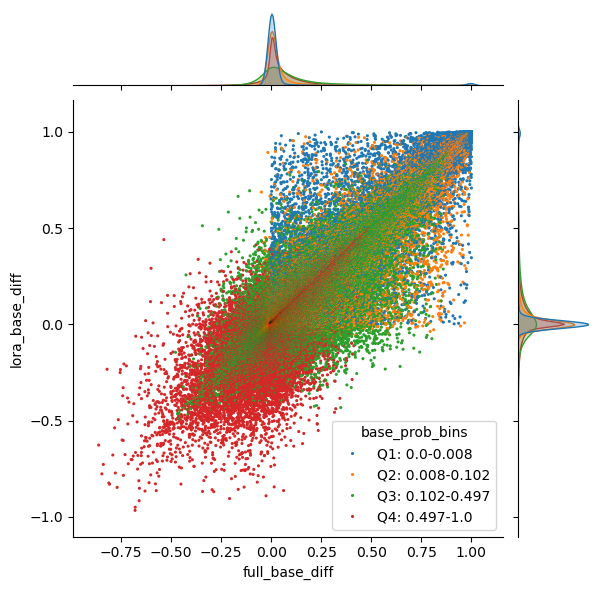

In [45]:
binned_base = bin_var(df=finetune_df_merged, var="base_prob")
sns.jointplot(data=binned_base, x="full_base_diff", y="lora_base_diff", s=5, linewidth=0, hue="base_prob_bins")

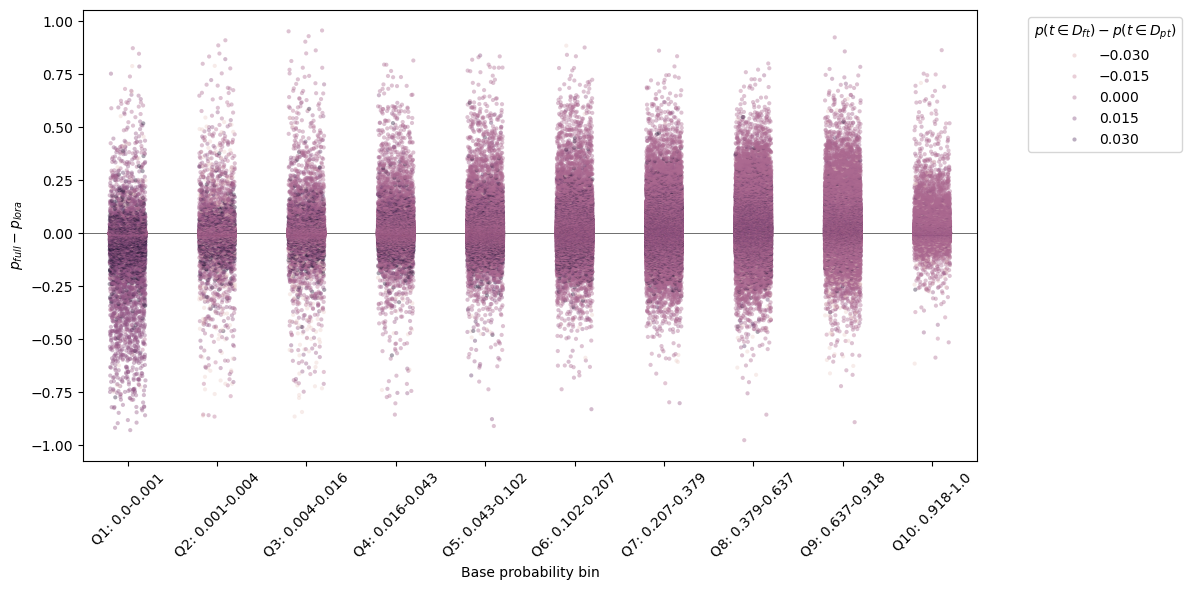

In [39]:
# Create scatter plot with jitter
plt.figure(figsize=(10, 6))

# Add jitter to the categorical x-axis
sns.stripplot(data=binned_base, 
             x="base_prob_bins", 
             y="full_lora_diff",
             jitter=0.2,  # Amount of jitter
             alpha=0.4,   # Transparency of points
             size=3, 
             hue="rel_prev")      # Point size

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.4)

# Modify bin labels and layout
plt.xticks(rotation=45)
plt.xlabel("Base probability bin")
plt.ylabel(r"$p_{full} - p_{lora}$")
plt.tight_layout()

# Modify legend
plt.legend(title=r"$p(t \in D_{ft}) - p(t \in D_{pt})$", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

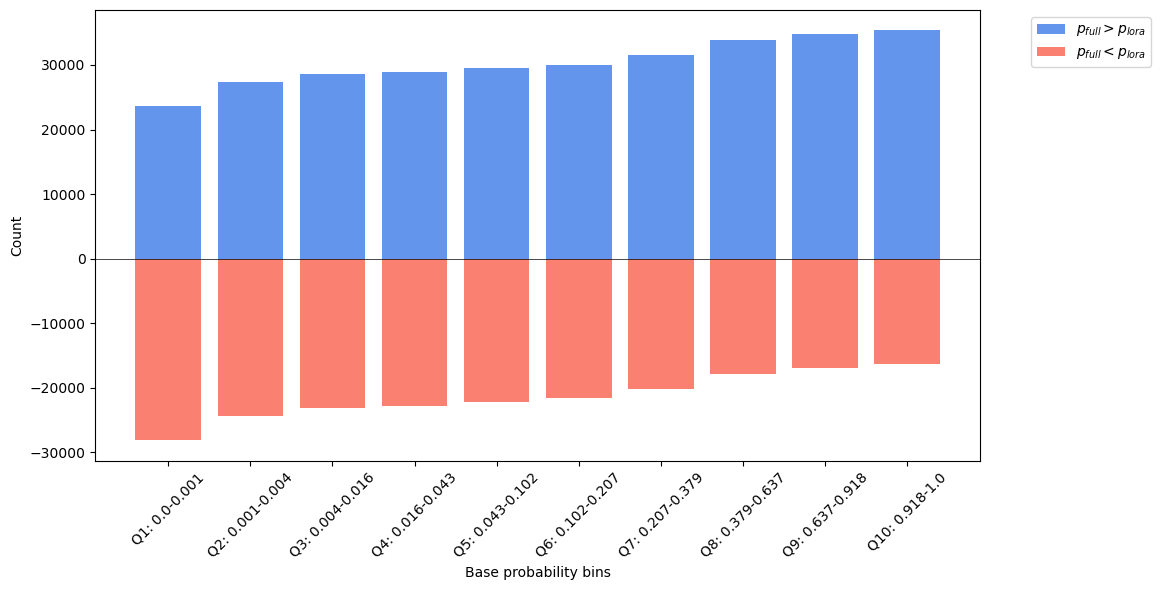

In [40]:
# Calculate counts for each bin, split by whether full_lora_diff is positive or negative
positive_counts = binned_base[binned_base['full_lora_diff'] > 0].groupby('base_prob_bins').size()
negative_counts = binned_base[binned_base['full_lora_diff'] < 0].groupby('base_prob_bins').size()

# Create mirror bar plot
plt.figure(figsize=(10, 6))

# Plot positive differences (above 0)
plt.bar(positive_counts.index, positive_counts, label=r"$p_{full} > p_{lora}$", color='cornflowerblue')

# Plot negative differences (below 0)
plt.bar(negative_counts.index, -negative_counts, label=r"$p_{full} < p_{lora}$", color='salmon')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Set labels
plt.xlabel("Base probability bins")
plt.ylabel("Count")

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# Create equal-width bins for base probabilities
n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)  # creates n_bins + 1 edges from 0 to 1
bin_labels = [f'[{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f})' for i in range(n_bins)]

# Assign bins using cut (not qcut) to ensure probabilities match their ranges
binned_base['base_prob_bins_equal'] = pd.cut(binned_base['base_prob'], 
                                            bins=bin_edges, 
                                            labels=bin_labels,
                                            include_lowest=True)

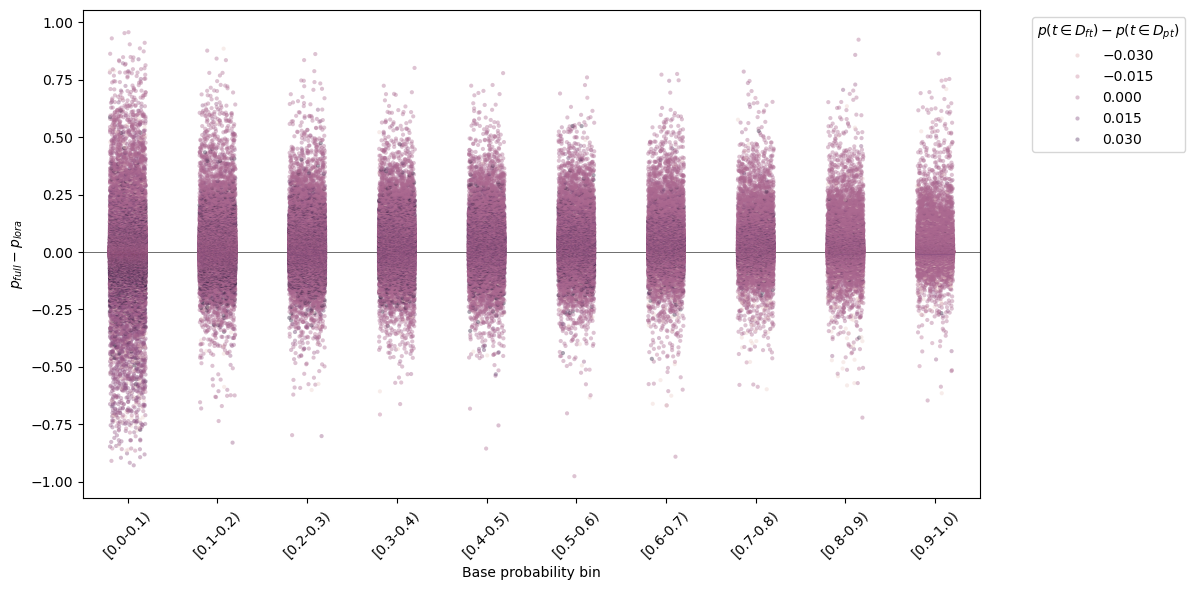

In [46]:
# Create scatter plot with jitter
plt.figure(figsize=(10, 6))

# Add jitter to the categorical x-axis
sns.stripplot(data=binned_base, 
             x="base_prob_bins_equal", 
             y="full_lora_diff",
             jitter=0.2,  # Amount of jitter
             alpha=0.4,   # Transparency of points
             size=3, 
             hue="rel_prev")      # Point size

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.4)

# Modify bin labels and layout
plt.xticks(rotation=45)
plt.xlabel("Base probability bin")
plt.ylabel(r"$p_{full} - p_{lora}$")
plt.tight_layout()

# Modify legend
plt.legend(title=r"$p(t \in D_{ft}) - p(t \in D_{pt})$", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

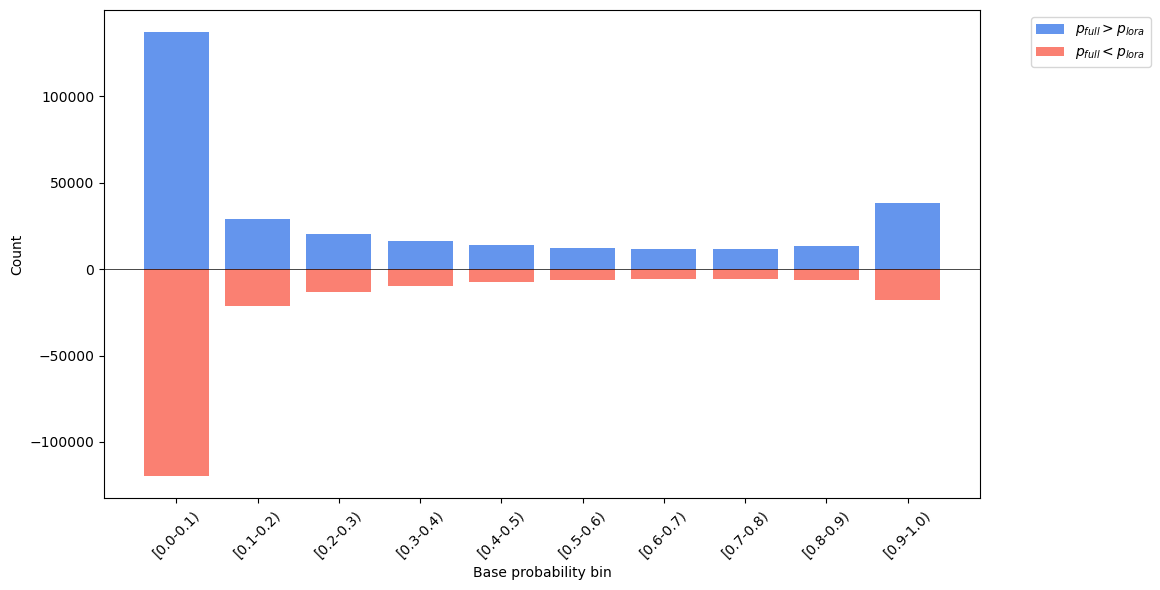

In [45]:


# Calculate counts for each bin, split by whether full_lora_diff is positive or negative
positive_counts = binned_base[binned_base['full_lora_diff'] > 0].groupby('base_prob_bins_equal').size()
negative_counts = binned_base[binned_base['full_lora_diff'] < 0].groupby('base_prob_bins_equal').size()

# Create mirror bar plot
plt.figure(figsize=(10, 6))

# Plot positive differences (above 0)
plt.bar(positive_counts.index, positive_counts, label=r"$p_{full} > p_{lora}$", color='cornflowerblue')

# Plot negative differences (below 0)
plt.bar(negative_counts.index, -negative_counts, label=r"$p_{full} < p_{lora}$", color='salmon')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Set labels
plt.xlabel("Base probability bin")
plt.ylabel("Count")

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

base_prob_bins_equal     base_prob   base_prob_bins
0                 [0.7-0.8)  5.493074e-01  Q8: 0.379-0.637
1                 [0.0-0.1)  1.416771e-09    Q1: 0.0-0.001
2                 [0.0-0.1)  3.142819e-09    Q1: 0.0-0.001
3                 [0.4-0.5)  8.772501e-02  Q5: 0.043-0.102
4                 [0.0-0.1)  9.792849e-10    Q1: 0.0-0.001
...                     ...           ...              ...
516877            [0.1-0.2)  7.790343e-04  Q2: 0.001-0.004
516878            [0.8-0.9)  8.881302e-01  Q9: 0.637-0.918
516879            [0.2-0.3)  4.571220e-03  Q3: 0.004-0.016
516880            [0.2-0.3)  1.322925e-02  Q3: 0.004-0.016
516881            [0.2-0.3)  8.548080e-03  Q3: 0.004-0.016

[516882 rows x 3 columns]

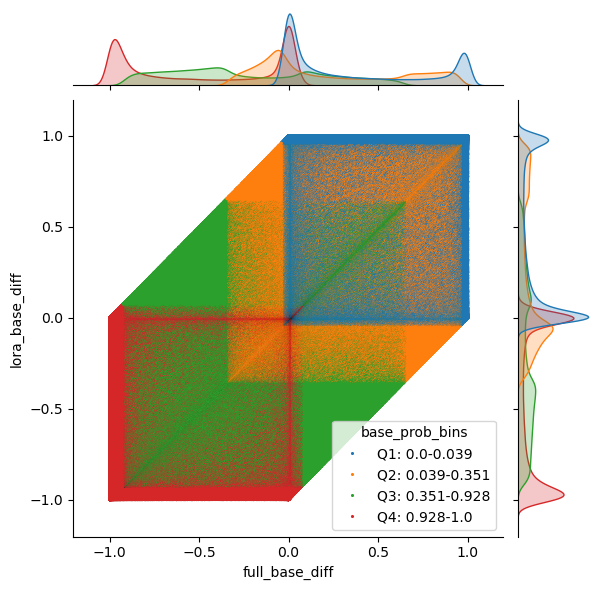

In [46]:
binned_base = bin_var(df=pretrain_df_merged, var="base_prob")
sns.jointplot(data=binned_base, x="full_base_diff", y="lora_base_diff",  s=5, linewidth=0, hue="base_prob_bins")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


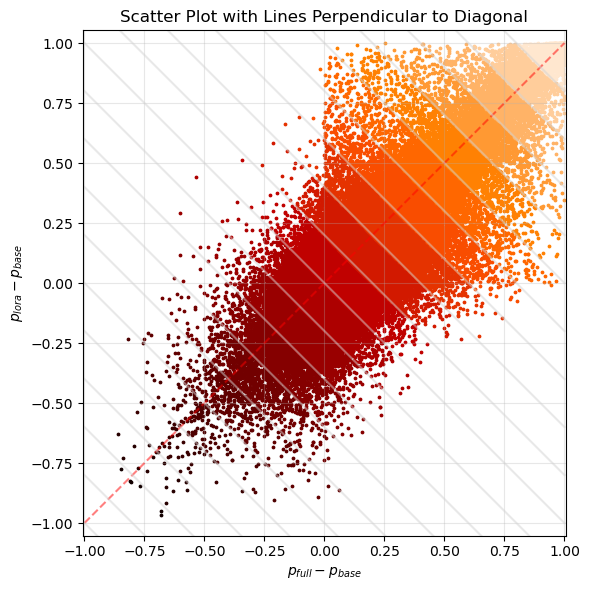

In [47]:
bar_plot = pd.DataFrame(columns=["c1", "c2", "total", "lora_greater", "full_greater"])

# Create scatter plot
plt.figure(figsize=(6, 6))
# Draw diagonal line for reference
plt.plot([-1, 1], [-1, 1], 'r--', alpha=0.5, label=r'$p_{full} = p_{lora}$')

# Draw perpendicular lines
n_blocks = 20 
c_values = np.linspace(-2, 2, n_blocks + 1)
c_ranges = [(c_values[i], c_values[i+1]) for i in range(len(c_values)-1)]
colors = plt.cm.gist_heat(np.linspace(0, 1, n_blocks + 1))
for i, (c1, c2) in enumerate(c_ranges):
    x = finetune_df_merged["full_base_diff"]
    y = finetune_df_merged["lora_base_diff"]
    mask = ((c1 < y + x) & (y + x <= c2))
    masked_df = finetune_df_merged[mask]
    x_list, y_list = masked_df["full_base_diff"], masked_df["lora_base_diff"]
    total_points = len(masked_df)
    lora_greater = len(masked_df[masked_df["full_lora_diff"] > 0])
    full_greater = len(masked_df[masked_df["full_lora_diff"] < 0])

    p_x = np.array([1, -1])
    p_y = -p_x + c1
    new_row = {"c1": c1, "c2": c2, "total": total_points, "lora_greater": lora_greater, "full_greater": full_greater}
    bar_plot.loc[len(bar_plot)] = new_row
    bar_plot.reset_index(drop=True, inplace=True)

    plt.plot(p_x, p_y, 'g-', color='lightgray', alpha=0.5)
    plt.scatter(x_list, y_list, color=colors[i], s=3)

plt.xlabel(r'$p_{full} - p_{base}$')
plt.ylabel(r'$p_{lora} - p_{base}$')
plt.title('Scatter Plot with Lines Perpendicular to Diagonal')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tight_layout()

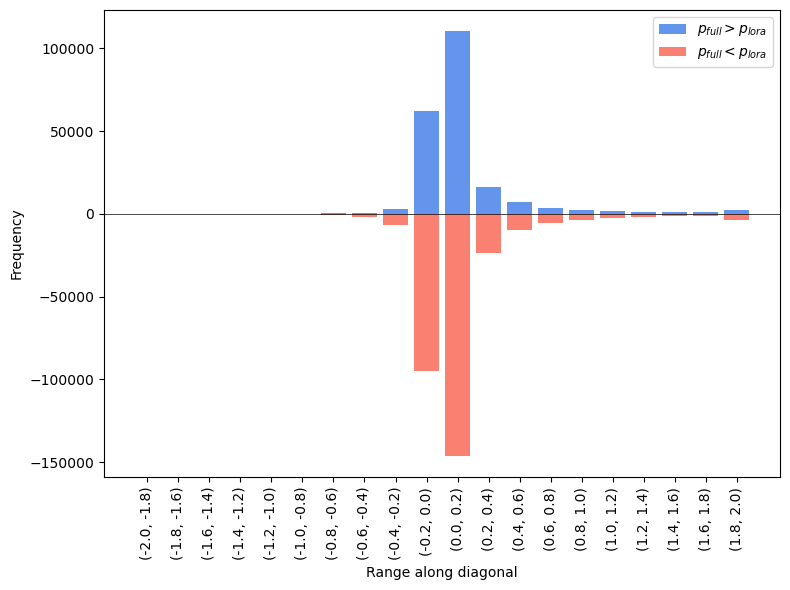

In [66]:
# Mirror Bar plot of the distribution of points along the diagonal with respect to the range
plt.figure(figsize=(8, 6))
bar_plot["range"] = "(" + round(bar_plot["c1"], 1).astype(str) + ", " + round(bar_plot["c2"], 1).astype(str) + ")"

# Create mirror bar plot
plt.bar(bar_plot["range"], bar_plot["full_greater"], label=r"$p_{full} > p_{lora}$", color='cornflowerblue')
plt.bar(bar_plot["range"], -bar_plot["lora_greater"], label=r"$p_{full} < p_{lora}$", color='salmon')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Set labels
plt.xlabel("Range along diagonal")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

plt.tight_layout()

# add legend
plt.legend()


### Comparing frequency across distribution by quantiles

In [56]:
# Ordering tokens by curr_token_freq
def order_by_freq(df, var, ascending=False):
    ordered_df = df[["curr_token", var]]
    ordered_df = ordered_df.sort_values(by=var, ascending=ascending)
    ordered_df = ordered_df.drop_duplicates(subset="curr_token")
    ordered_df.reset_index(drop=True, inplace=True)
    return ordered_df

In [91]:
def plot_quartile_vocab_dist(df, top_k=100, ascending=False):

    # create a plot with 10 x 4 subplots
    num_rows = 11
    num_cols = 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    # Flatten axs for easier indexing
    axs = axs.flatten()

    # create curr_token_freq_bins
    curr_token_freq_bins = bin_var(df=df, var="curr_token_freq", n=10)
    pt_curr_token_freq_bins = bin_var(df=df, var="pt_curr_token_freq", n=10)

    # Get unique values of curr_token_freq_bins
    curr_token_freq_bins = curr_token_freq_bins['curr_token_freq_bins'].unique()
    pt_curr_token_freq_bins = pt_curr_token_freq_bins['pt_curr_token_freq_bins'].unique()

    uniq_bins = [curr_token_freq_bins, pt_curr_token_freq_bins]

    curr_token_freq_sorted = order_by_freq(finetune_df_merged, "curr_token_freq", ascending=ascending)
    pt_curr_token_freq_sorted = order_by_freq(finetune_df_merged, "pt_curr_token_freq", ascending=ascending)
    
    # Limit to top 50 tokens for clarity
    curr_token_freq_sorted = curr_token_freq_sorted.loc[:top_k]
    pt_curr_token_freq_sorted = pt_curr_token_freq_sorted.loc[:top_k]

    sorted_dfs = [curr_token_freq_sorted, pt_curr_token_freq_sorted]#, rel_prev_sorted]
    vars = ["curr_token_freq", "pt_curr_token_freq"]#, "rel_prev"]

    # for i in range(len(sorted_dfs)):
        # plot the sorted_dfs


    for j in range(len(sorted_dfs)):
        bin_df = uniq_bins[j]
        for i in range(num_rows):
            

            # get index in flattened array for first column
            idx = 1 + i * num_cols + j
            
            if (idx - 1) % num_cols == 0: 
                # no axes
                axs[idx-1].set_axis_off()
                if i != 0:
                    axs[idx-1].text(0.5, 0.5, f'Q{i}', ha='center', va='center', fontsize=20)
                
            # skip first row
            if i == 0: 
                continue

            quant_df = finetune_df_merged[finetune_df_merged[f'{vars[j]}_bins'] == bin_df[i-1]]
            quant_df_sorted = order_by_freq(quant_df, f'{vars[j]}')
            # sort the quant_df_sorted by order of curr_token curr_token_freq_sorted
            quant_df_sorted = quant_df_sorted.merge(curr_token_freq_sorted[["curr_token"]], on="curr_token", how="right")
            # replace nan with 0
            quant_df_sorted.fillna(0, inplace=True)
            sns.barplot(x=quant_df_sorted['curr_token'], y=quant_df_sorted[f'{vars[j]}'], ax=axs[idx])
            

            # remove x and y labels
            axs[idx].set_xlabel('')
            axs[idx].set_ylabel('')

            # Remove ticks
            axs[idx].set_xticks([])
            axs[idx].set_yticks([])

        
    plt.show()


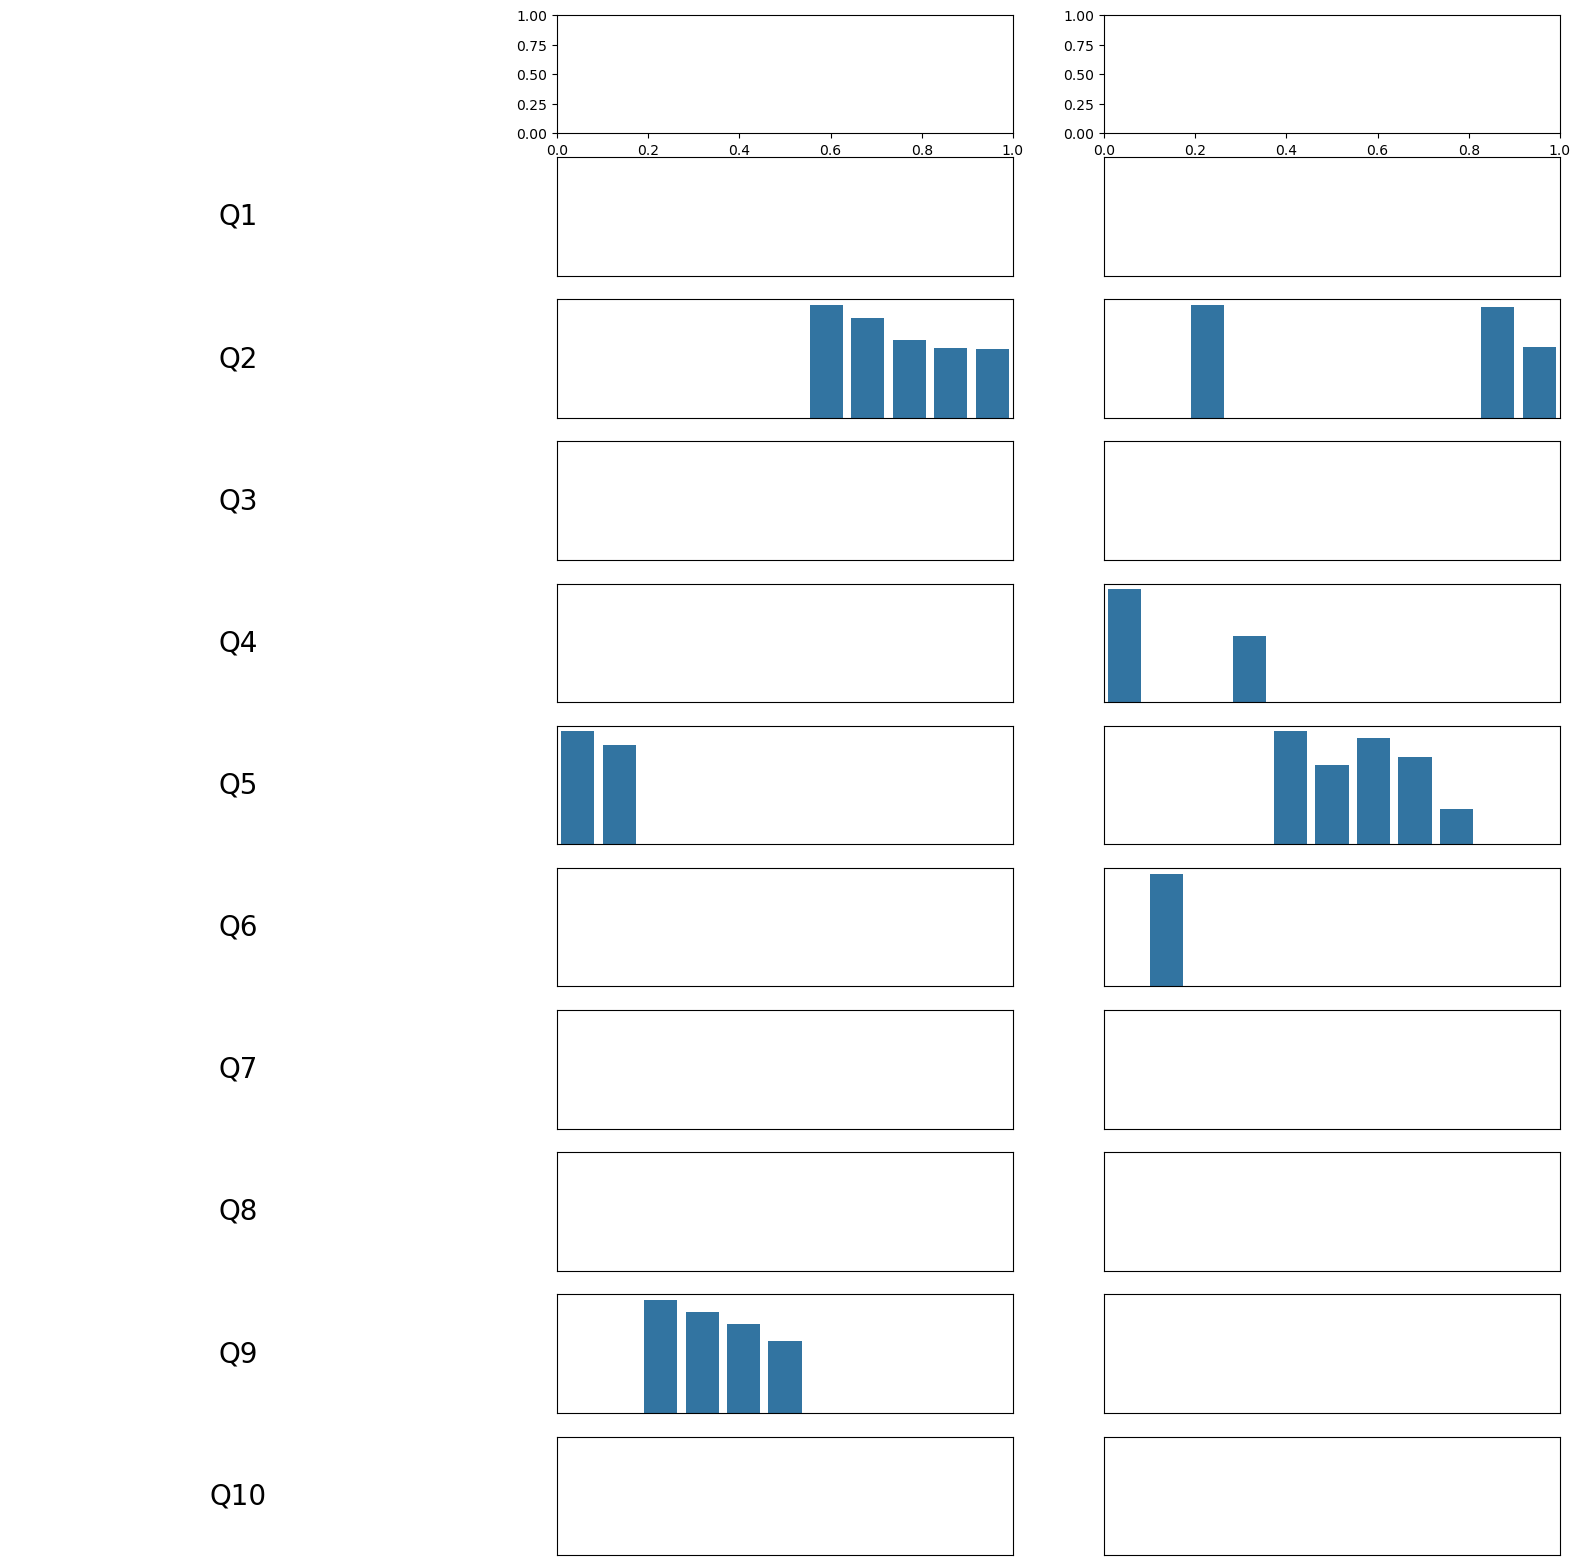

In [92]:
plot_quartile_vocab_dist(finetune_df_merged, top_k=10)